# Predictive Modeling - AlphaCare Insurance

# **Objective:**  
# 1. Fit Linear Regression models for top ZipCodes  
# 2. Build ML models (Random Forest, XGBoost) to predict TotalClaims  
# 3. Analyze feature importance using SHAP

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load and Clean Data

In [31]:
df = pd.read_csv('../data/insurance_claims.csv', low_memory=False, sep='|')

# Fix numeric columns

In [33]:
numeric_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 
                'CalculatedPremiumPerTerm', 'Cylinders', 'CubicCapacity', 'Kilowatts']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Check which columns exist

In [34]:
print(df.columns.tolist())

['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims']


# Map Gender

In [35]:
if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].map({'Mr':'Male', 'Mrs':'Female'}).fillna('Unknown')

# Filter rows with claims

In [36]:
risk_df = df[df['TotalClaims'] > 0].copy()

# Convert numeric columns

In [15]:
numeric_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CalculatedPremiumPerTerm', 'Cylinders', 'Cubiccapacity', 'Kilowatts']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Filter for risk modeling

In [16]:
risk_df = df[df['TotalClaims'] > 0].copy()

# Clean categorical columns

In [37]:
cat_cols = ['VehicleType', 'Make', 'Bodytype', 'Province', 'Gender', 'PostalCode']
for col in cat_cols:
    if col in risk_df.columns:
        risk_df[col] = risk_df[col].astype(str)

# Task 1: Linear Regression per ZipCode
# Fit a model predicting TotalClaims based on TotalPremium and SumInsured for top 5 ZipCodes.

In [38]:
top_zips = risk_df['PostalCode'].value_counts().head(5).index

print("--- Linear Regression Coefficients per ZipCode ---")
for zipcode in top_zips:
    subset = risk_df[risk_df['PostalCode'] == zipcode]
    
    if len(subset) > 10:
        X = subset[['TotalPremium', 'SumInsured']]
        y = subset['TotalClaims']
        lr = LinearRegression()
        lr.fit(X, y)
        print(f"Zip: {zipcode} | R2: {lr.score(X, y):.3f} | Intercept: {lr.intercept_:.1f} | Coeff: {lr.coef_}")


--- Linear Regression Coefficients per ZipCode ---
Zip: 2000 | R2: 0.333 | Intercept: 3196.4 | Coeff: [5.34785978e+01 2.07469390e-02]
Zip: 122 | R2: 0.281 | Intercept: 4201.6 | Coeff: [-11.05141842   0.15299407]
Zip: 299 | R2: 0.503 | Intercept: 4609.7 | Coeff: [-67.38768202   0.25737529]
Zip: 8000 | R2: 0.218 | Intercept: 15347.2 | Coeff: [-22.019546   0.118423]
Zip: 7784 | R2: 0.229 | Intercept: 4152.8 | Coeff: [4.52847675 0.17996429]


# 3. Machine Learning Pipeline

# Features

In [39]:
features = ['VehicleType', 'Make', 'BodyType', 'Province', 'Gender', 'PostalCode', 
            'SumInsured', 'CalculatedPremiumPerTerm', 'CubicCapacity', 'Kilowatts', 'Cylinders']
target = 'TotalClaims'

# Keep only existing columns

In [40]:
features = [f for f in features if f in risk_df.columns]

model_data = risk_df.dropna(subset=features + [target])
X = model_data[features]
y = model_data[target]

numeric_features = [f for f in ['SumInsured', 'CalculatedPremiumPerTerm', 'CubicCapacity', 'Kilowatts', 'Cylinders'] if f in X.columns]
categorical_features = [f for f in ['VehicleType', 'Make', 'BodyType', 'Province', 'Gender', 'PostalCode'] if f in X.columns]

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model A: Random Forest

In [41]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1))
])

print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"R2: {r2_score(y_test, y_pred_rf):.4f}")

Training Random Forest...
Random Forest Performance:
RMSE: 38388.71
MAE: 16839.18
R2: 0.0837


# Model B: XGBoost

In [42]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, n_jobs=-1))
])

print("\nTraining XGBoost...")
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

print("XGBoost Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"R2: {r2_score(y_test, y_pred_xgb):.4f}")


Training XGBoost...
XGBoost Performance:
RMSE: 37363.90
MAE: 16789.22
R2: 0.1319


# Task 3: SHAP Feature Importance

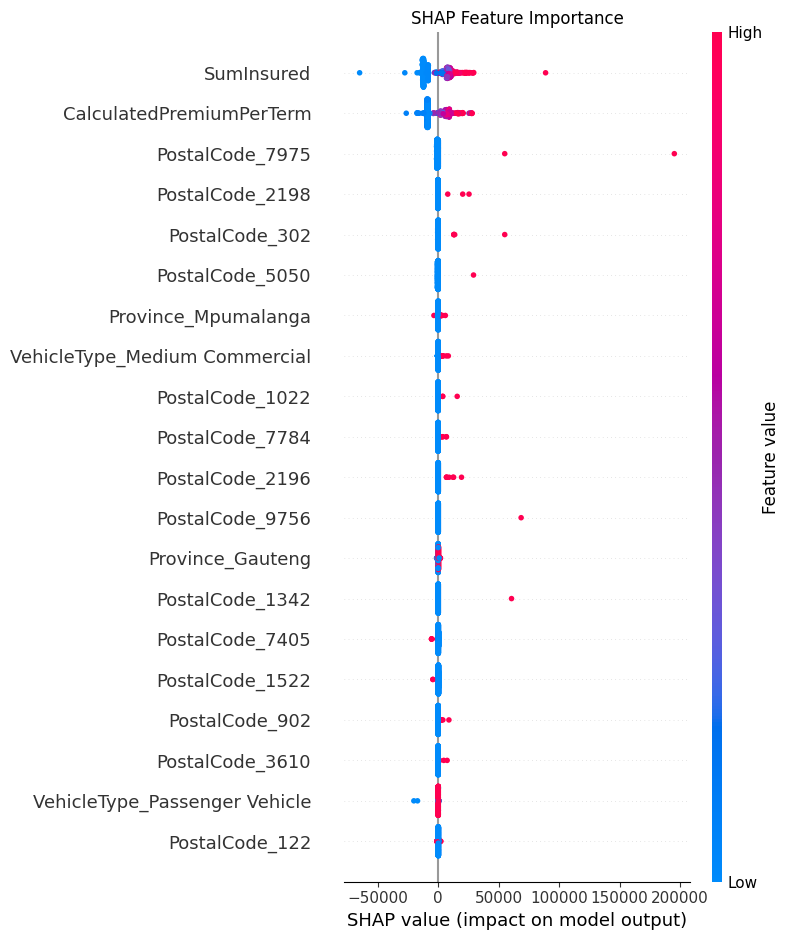

In [43]:
model = xgb_pipeline.named_steps['regressor']
processor = xgb_pipeline.named_steps['preprocessor']

X_train_transformed = processor.transform(X_train)

cat_encoder = processor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_feature_names)

explainer = shap.Explainer(model, X_train_transformed[:500])
shap_values = explainer(X_train_transformed[:500])

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_transformed[:500], feature_names=all_feature_names, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()